## Qustion 1

### a)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [05:10<00:00, 549kB/s]    


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


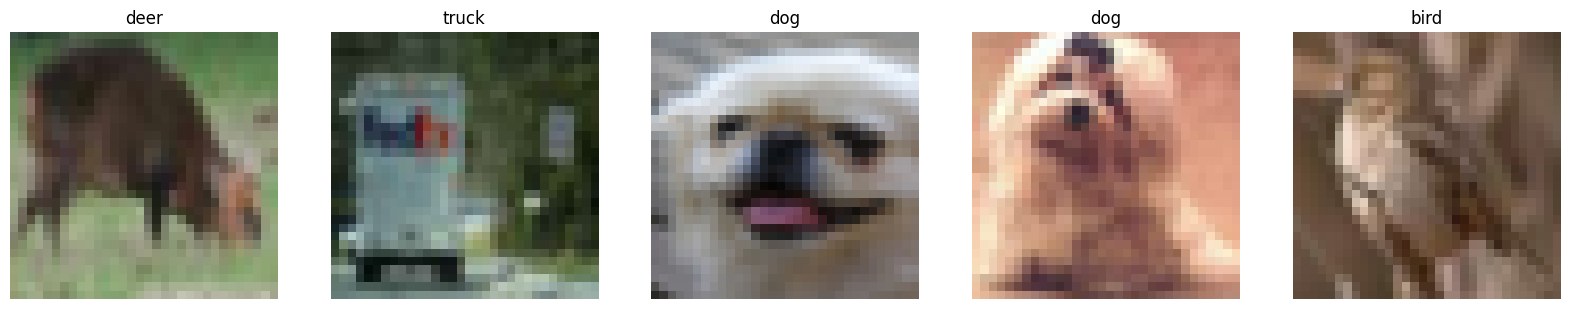

In [16]:
import numpy as np 

dataiter = iter(trainloader)
images, labels = next(dataiter)

# show five images in the training set
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # rearrange dimensions to (H, W, C)
    plt.axis('off')

fig, axes = plt.subplots(1, 5, figsize=(20, 6))
for i in range(5):
    ax = axes[i]
    plt.sca(ax)
    imshow(images[i])
    ax.set_title(classes[labels[i]])
plt.show()


In [ ]:
# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Hidden layer size
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w1 = torch.randn(Din, H) * std
b1 = torch.zeros(H)
w2 = torch.randn(H, K) * std
b2 = torch.zeros(K)

# Hyperparameters
iterations = 10
lr = 2e-6  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0  # Regularization
loss_history = []

In [31]:
# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float()  # Convert labels to one-hot

        # Forward pass
        h1 = torch.sigmoid(x_train.mm(w1) + b1)  # Hidden layer activation
        y_pred = h1.mm(w2) + b2  # Output layer activation

        # Loss calculation (Cross-Entropy Loss with regularization)
        loss = nn.CrossEntropyLoss()(y_pred, labels) + reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = y_pred - y_train_onehot  # Gradient of loss w.r.t. y_pred
        dh1 = dy_pred.mm(w2.t()) * h1 * (1 - h1)  # Gradient of hidden layer
        dw1 = x_train.t().mm(dh1) + reg * w1
        db1 = dh1.sum(dim=0)
        dw2 = h1.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)

        # Parameter update
        with torch.no_grad():
            w1 -= lr * dw1
            b1 -= lr * db1
            w2 -= lr * dw2
            b2 -= lr * db2

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1 / 10, Loss: 2.302591168642044
Epoch 2 / 10, Loss: 2.3025913650989533
Epoch 3 / 10, Loss: 2.302590273857117
Epoch 4 / 10, Loss: 2.3025903458595276
Epoch 5 / 10, Loss: 2.3025897057056426
Epoch 6 / 10, Loss: 2.302588749170303
Epoch 7 / 10, Loss: 2.3025891416072843
Epoch 8 / 10, Loss: 2.302588303089142
Epoch 9 / 10, Loss: 2.30258824467659
Epoch 10 / 10, Loss: 2.302587952852249


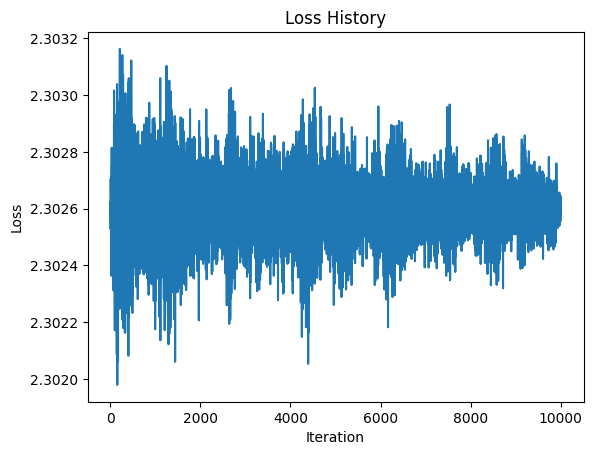

In [26]:
# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [27]:
# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        h1 = torch.sigmoid(x_train.mm(w1) + b1)
        y_train_pred = h1.mm(w2) + b2
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

Training accuracy: 10.00%


In [28]:
# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        h1 = torch.sigmoid(x_test.mm(w1) + b1)
        y_test_pred = h1.mm(w2) + b2
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()
test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 10.00%


## Question 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#convert MNIST image files into a Tensor of 4-dimensions(# of images, height, width, color channels)
transform = transforms.ToTensor()
train_data = datasets.MNIST(root = '/cnn_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root = '/cnn_data', train=False, download=True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [17]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [23]:
class LeNet5(nn.Module):
    def __init__(self) :
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        self.fc1 = nn.Linear(in_features=16 * 4  *4, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        # Convolutional layer
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        
        # Flatten layer
        x = x.view(-1, 16 * 4 * 4) 
        
        # Fully connected layer
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        
        return x

In [24]:
from torchsummary import summary
model = LeNet5()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
            Linear-3                   [-1, 84]          21,588
            Linear-4                   [-1, 10]             850
Total params: 25,010
Trainable params: 25,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.10
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [25]:
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1  #start batch number at 1
        y_pred = model(X_train)
        loss = criterian(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the firdt point
        batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True=1, False=0, sum those up
        train_corr += batch_corr
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print out some results
        if b%1000 == 0:
            print(f"Epoch: {i + 1} Batch: {b} Loss: {loss.item()}")
            
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    #Test
    with torch.no_grad(): # No gradient so we don't update our weights and biases with test data
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            loss = criterian(y_val, y_test)
        
            predicted = torch.max(y_val.data, 1)[1] # adding up the correct predictions
            batch_tst_corr = (predicted == y_test).sum() # how many we got correct from this batch. True=1, False=0, sum those up
            test_corr += batch_tst_corr
            
    test_losses.append(loss)
    test_correct.append(test_corr)

Epoch: 1 Batch: 1000 Loss: 1.4727826118469238
Epoch: 1 Batch: 2000 Loss: 1.461150884628296
Epoch: 1 Batch: 3000 Loss: 1.4611537456512451
Epoch: 2 Batch: 1000 Loss: 1.461213231086731
Epoch: 2 Batch: 2000 Loss: 1.4611501693725586
Epoch: 2 Batch: 3000 Loss: 1.4611859321594238
Epoch: 3 Batch: 1000 Loss: 1.461150884628296
Epoch: 3 Batch: 2000 Loss: 1.4613914489746094
Epoch: 3 Batch: 3000 Loss: 1.521315097808838
Epoch: 4 Batch: 1000 Loss: 1.4652750492095947
Epoch: 4 Batch: 2000 Loss: 1.4611843824386597
Epoch: 4 Batch: 3000 Loss: 1.4614381790161133
Epoch: 5 Batch: 1000 Loss: 1.4611501693725586
Epoch: 5 Batch: 2000 Loss: 1.4611568450927734
Epoch: 5 Batch: 3000 Loss: 1.4611505270004272
Epoch: 6 Batch: 1000 Loss: 1.4611506462097168
Epoch: 6 Batch: 2000 Loss: 1.4611515998840332
Epoch: 6 Batch: 3000 Loss: 1.461301326751709
Epoch: 7 Batch: 1000 Loss: 1.4662725925445557
Epoch: 7 Batch: 2000 Loss: 1.4611501693725586
Epoch: 7 Batch: 3000 Loss: 1.523627519607544
Epoch: 8 Batch: 1000 Loss: 1.52365386486

In [29]:
train_accuracy = train_correct[-1].item() / 60000 * 100
test_accuracy = test_correct[-1].item() / 10000 * 100
print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 99.46%
Test accuracy: 98.70%
